# Final Project

### 獲取歷史資料

In [1]:
from finlab.data import Data

data = Data()

rev = data.get("當月營收")
PB = data.get("股價淨值比")

open = data.get("開盤價")
high = data.get("最高價")
low = data.get("最低價")
close = data.get("收盤價")
volume= data.get('成交股數')


rev.index = rev.index.shift(5, "d")

from finlab.data import Data
### 計算features

In [2]:
##import pandas as ta
##ta.
#
#
#from finlab.data import Data
#data = Data()
#import finlab.ml as ml
#import pandas as pd
#
#twii_df = pd.DataFrame({
#    'open' : data.get("開盤價"),
#    'high': data.get("最高價"),
#    'low': data.get("最低價"),
#    "close": data.get("收盤價"),
#})
#
#indicators = ['STOCH', 'RSI']
#multiplier = [1,5,10,20,30]
#dataset = ml.talib_features(twii_df,indicators, multiplier)
#feature_names - dataset.columns
#dataset ['return'] = twii.shift(-10) / twii

In [3]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

def yoy(n):
    return (rev / rev.shift(12)).shift(n)


def PB(n):
    return PB




features = {
    'mom1': mom(1),
    'mom2': mom(2),
    'mom3': mom(3),
    'mom4': mom(4),
    'mom5': mom(5),
    'mom6': mom(6),
    'mom7': mom(7),
    'mom8': mom(8),
    'mom9': mom(9),
    
    'yoy': yoy(1),
    'delta_yoy':yoy(1)-yoy(2),
    
    #"PB":PB(1),
    
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    'bias60': bias(60),
    'bias120': bias(120),
    'bias240': bias(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc120': acc(120),
    'acc240': acc(240),
    
    'rsv5': rsv(5),
    'rsv10': rsv(10),
    'rsv20': rsv(20),
    'rsv60': rsv(60),
    'rsv120': rsv(120),
    'rsv240': rsv(240),
}


### 製作dataset

##### 設定買賣頻率

In [4]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-11-15', '2021-12-15', '2022-01-15', '2022-02-15',
               '2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15',
               '2022-07-15', '2022-08-15'],
              dtype='datetime64[ns]', name='date', length=211, freq=None)

##### 將dataframe 組裝起來

In [5]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [6]:

for name, f in features.items():
    features[name] = f.unstack()

In [7]:
import pandas as pd
dataset = pd.DataFrame(features)

In [8]:
feature_names = list(dataset.columns)

### 新增 label

In [9]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

D:\Finlab\AI選股策略\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  all_index = (df.index | item.index).sort_values()
D:\Finlab\AI選股策略\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  all_index = (df.index | item.index).sort_values()
D:\Finlab\AI選股策略\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  all_index = (df.index | item.index).sort_values()
D:\Finlab\AI選股策略\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) inst

### 刪除太大太小的歷史資料

In [10]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6','yoy', 'delta_yoy'], thresh=0.01)

print(dataset_drop_extreme_case.shape)

(428541, 31)
(398596, 31)


In [11]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [12]:
dataset_drop_extreme_case.index.get_level_values("date")

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-11-15', '2021-12-15', '2022-01-15', '2022-02-15',
               '2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15',
               '2022-07-15', '2022-08-15'],
              dtype='datetime64[ns]', name='date', length=398596, freq=None)

In [13]:
dataset_train = dataset_dropna.loc[:'2020']
dataset_test = dataset_dropna.loc['2021':]

train = (dataset_train[feature_names], dataset_train['return']  >1)#>1
test = (dataset_test[feature_names], dataset_train['return']  >1) #>1

C:\Users\User\.conda\envs\finlab\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  


### 神經網路模型

In [14]:
import os

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=1000, #1000
                    epochs=200, #225
                    verbose=1,
                    validation_split=0.1, )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3000      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 13,201
Trainable params: 13,201
Non-trainable params: 0
_________________________________________________________________
start fitting
Epoch 1/200
150/150 [==============================] - ETA: 0s - loss: 0.186 - ETA: 0s - loss: 0.153 - ETA: 0s - loss: 0.119 - ETA: 0s - loss: 0.106 - ETA: 0s - loss: 0.100 - ETA: 0s - loss: 0.095 - ETA: 0s - loss: 0.093 - ETA: 0s - los

### 結果

In [16]:
import tensorflow as tf

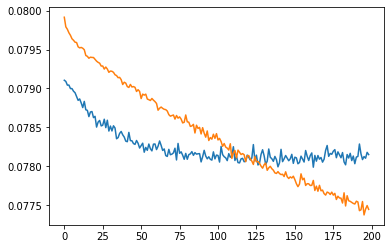

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

### lightgbm Model

In [18]:
import lightgbm

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [test],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 30

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

### 執行參數回測
gs.fit(*train, **fit_params)

### 顯示最佳參數
print(gs.best_estimator_)
# 得分gs.score(*test)
###提示音
import winsound
duration = 1000  # millisecond
freq = 440  # Hz
winsound.Beep(freq, duration)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\User\.conda\envs\finlab\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\.conda\envs\finlab\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\.conda\envs\finlab\lib\site-packages\lightgbm\sklearn.py", line 726, in fit
    callbacks=callbacks)
  File "C:\Users\User\.conda\envs\finlab\lib\site-packages\lightgbm\sklearn.py", line 499, in fit
    callbacks=callbacks)
  File "C:\Users\User\.conda\envs\finlab\lib\sit

LightGBMError: Length of label is not same with #data

In [ ]:
import lightgbm as lgb
cf = lgb.LGBMRegressor(n_estimators=500)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])
cf.score

### Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

In [ ]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [ ]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = cf.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = cf2.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

# backtest

In [ ]:
import math


dates = sorted(list(set(dataset_drop.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time, 
        ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6','yoy', 'delta_yoy'], thresh=0.01)
    
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
    
    condition = (rank >= rank.nlargest(20).iloc[-1]) 
    r = dataset_time['return'][condition].mean()

    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

rs = pd.Series(rs, index=dates)['2021':].cumprod()

s0050 = close['0050']['2021':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()



### 當月持股狀況

In [ ]:
dataset.index.levels[1]

In [ ]:
# get the latest dataset
last_date = "2022-07-15"#dataset.index.levels[1].max()
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6','yoy', 'delta_yoy'], thresh=0.01)


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
condition = (rank >= rank.nlargest(20).iloc[-1]) 

# plot rank distribution
rank.hist(bins=20)


# show the best 20 stocks
slist1 = rank[condition].reset_index()['stock_id']

# 平均分配資產於股票之中

In [ ]:
close = data.get("收盤價")

money = 50000*4
stock_prices = close[rank[condition].reset_index()['stock_id']].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000
